In [1]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import sys
import os
import numpy as np
import pandas as pd
sys.path.insert(0, '../../')

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader
from configuration import MODEL_INPUT_DATA_PATH


alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')



RendererRegistry.enable('default')

In [2]:
MODEL_INPUT_DATA_PATH

'/Users/murphybre/Desktop/UMichigan/Fall2024/siads699_capstone/music_modeling_capstone/project_data_source/model_input_data/'

In [3]:
full_model_data = ModelDataLoader('003')
#full_model_data.df.to_csv('output.csv', index=False) 

In [6]:
data_df = pd.read_csv(MODEL_INPUT_DATA_PATH +'output.csv')
data_df_parquet = full_model_data.df

In [7]:
data_df.head()

track_id dataset                                         audio_path   label  \
0        2     fma  /project_data_source/free_music_archive/fma_sm...  hiphop   
1        5     fma  /project_data_source/free_music_archive/fma_sm...  hiphop   
2       10     fma  /project_data_source/free_music_archive/fma_sm...     pop   
3      140     fma  /project_data_source/free_music_archive/fma_sm...    folk   
4      141     fma  /project_data_source/free_music_archive/fma_sm...    folk   

  fma_genre_top fma_genres fma_genres_all  sampling_rate  \
0       Hip-Hop       [21]           [21]        44100.0   
1       Hip-Hop       [21]           [21]        44100.0   
2           Pop       [10]           [10]        44100.0   
3          Folk       [17]           [17]        44100.0   
4          Folk       [17]           [17]        44100.0   

                                            features  spectral_centroids_mean  \
0  [ 3.6839976e+03  1.2325847e+00 -4.5687148e-01 ...                3683.9976   
1  [ 2.9283987e+03  6.8091089e-01  2.2613911e-02 ...                2928.3987   
2  [ 2.78679346e+03 -8.54560912e-01 -7.63878301e-...                2786.7935   
3  [ 1.95734814e+03  1.38313627e+00  3.51598054e-...                1957.3481   
4  [ 1.7686066e+03  1.1223010e+00 -9.9131316e-02 ...                1768.6066   

   ...  zero_crossing_rate_mean  rms_mean  chroma_stft_mean  mfccs_mean  \
0  ...                 0.098364  0.141225          0.424169   -1.742610   
1  ...                 0.059334  0.145243          0.475249    1.318398   
2  ...                 0.080989  0.186656          0.430406    2.244156   
3  ...                 0.027256  0.068459          0.450882   -3.624867   
4  ...                 0.034120  0.100852          0.341356   -4.471582   

      onset       tempo   contrast   tonnetz  mfccs_min  mfccs_max  
0  1.403928  166.708660  21.300428  0.022087 -505.49920  196.86868  
1  1.384270   99.384020  21.096779  0.005648 -528.11620  209.44308  
2  1.123551  112.347145  20.851960 -0.033316 -537.19720  229.15515  
3  1.135973  107.666016  21.727667  0.012266 -592.89580  199.95080  
4  0.881413  120.185320  23.655104 -0.003315 -536.54694  222.20863  

[5 rows x 24 columns]

In [8]:
data_df_parquet.head()

index track_id dataset                                         audio_path  \
0      0   000002     fma  /project_data_source/free_music_archive/fma_sm...   
1      2   000005     fma  /project_data_source/free_music_archive/fma_sm...   
2      3   000010     fma  /project_data_source/free_music_archive/fma_sm...   
3     15   000140     fma  /project_data_source/free_music_archive/fma_sm...   
4     16   000141     fma  /project_data_source/free_music_archive/fma_sm...   

    label fma_genre_top fma_genres fma_genres_all  file_available  \
0  hiphop       Hip-Hop       [21]           [21]             1.0   
1  hiphop       Hip-Hop       [21]           [21]             1.0   
2     pop           Pop       [10]           [10]             1.0   
3    folk          Folk       [17]           [17]             1.0   
4    folk          Folk       [17]           [17]             1.0   

   sampling_rate  ... zero_crossing_rate_mean  rms_mean  chroma_stft_mean  \
0          44100  ...                0.098364  0.141225          0.424169   
1          44100  ...                0.059334  0.145243          0.475249   
2          44100  ...                0.080989  0.186656          0.430406   
3          44100  ...                0.027256  0.068459          0.450882   
4          44100  ...                0.034120  0.100852          0.341356   

   mfccs_mean     onset       tempo   contrast   tonnetz   mfccs_min  \
0   -1.742610  1.403928  166.708664  21.300203  0.022087 -505.499176   
1    1.318397  1.384270   99.384018  21.096722  0.005648 -528.116272   
2    2.244156  1.123551  112.347145  20.852177 -0.033316 -537.197205   
3   -3.624865  1.135973  107.666016  21.727451  0.012266 -592.895813   
4   -4.471582  0.881413  120.185318  23.654802 -0.003315 -536.546936   

    mfccs_max  
0  196.868652  
1  209.443054  
2  229.155151  
3  199.950806  
4  222.208649  

[5 rows x 26 columns]

# Examine the data & features

## Check missing values

In [9]:
missing_data = data_df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']

missing_chart = alt.Chart(missing_data).mark_bar().encode(
    x='Column:N',
    y='Missing Count:Q',
    color = 'Missing Count:Q'
).properties (title='# of missing values', height=300, width=750)

missing_chart

alt.Chart(...)

## Check correlation between variables

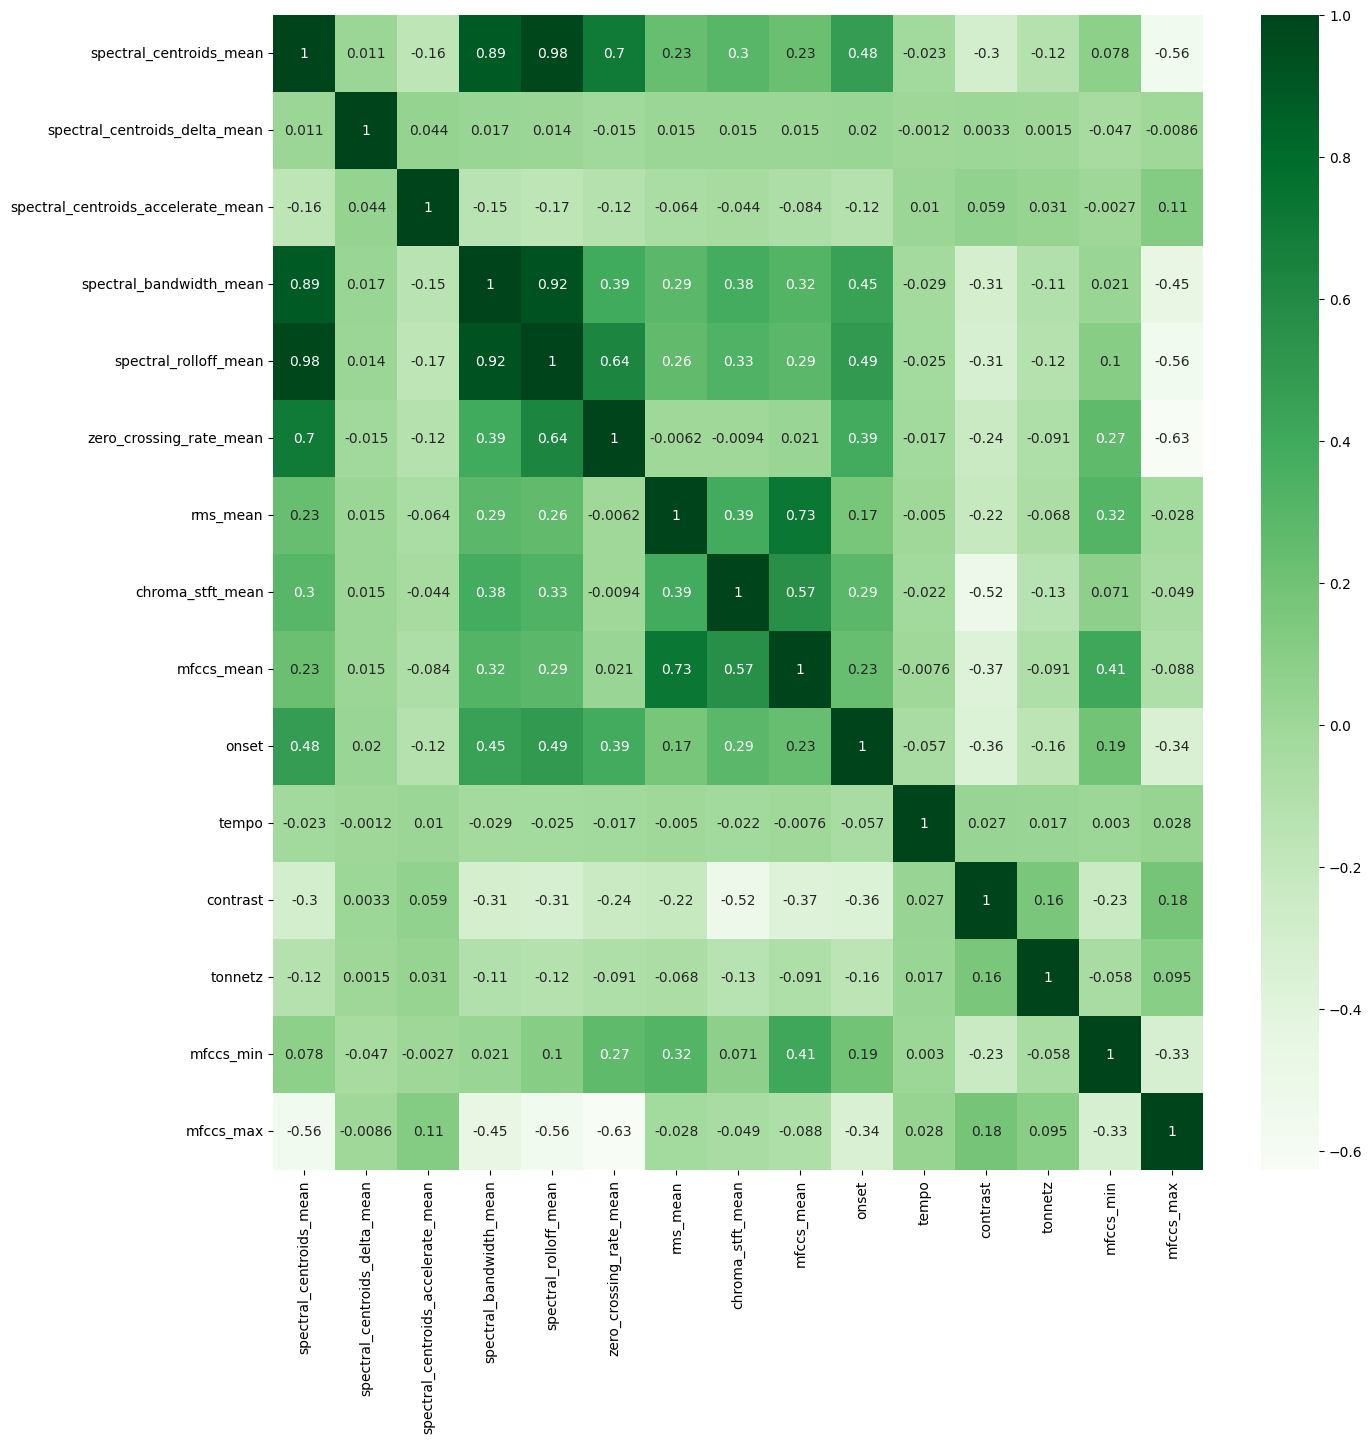

In [10]:
# check correlation between vars
matrix = data_df[full_model_data.feature_names].corr()

plt.figure(figsize=(15, 15))

heatmap = sns.heatmap(matrix, cmap="Greens", annot=True)

plt.show()


certain features are highly correlated; we might want to take a note of that as it might be important depending on what algorithm we use. 

spectral bandwidth; spectral roll off; spectral centroids are highly correlated 

## Check var distribution be genre 

In [11]:
def box_plot(y_col):
    chart = alt.Chart(data_df).mark_boxplot(extent="min-max").encode(
        alt.X("label:N"),
        alt.Y(y_col).scale(zero=False),
        alt.Color("label:N").legend(None),
    )
    return chart

#box_plot('sspectral_centroids_mean:Q') & box_plot('rms_mean') &  box_plot('mfccs_mean')| box_plot('spectral_centroids_delta_mean') & box_plot('spectral_centroids_accelerate_mean') & box_plot('spectral_rolloff_mean') | box_plot('zero_crossing_rate_mean') & box_plot('chroma_stft_mean') & box_plot('spectral_bandwidth_mean')


In [18]:
#new vars
box_plot('tempo') & box_plot('tonnetz')  | box_plot('onset') & box_plot('contrast') | box_plot('mfccs_min') & box_plot('mfccs_max')

alt.HConcatChart(...)

two variables (spectral_centroids_accelerate and spectral_centroids_delta) do not show much variablity by genre. These variables might not be the best predictors of a genre. Consider exluding these two variables and maybe picking different ones. 


## Distribution by var and genre 

In [47]:
selection = alt.selection_multi(fields=['label'])
color = alt.condition(selection,
                      alt.Color('label:N', legend=None),
                      alt.value('lightgray'))

opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))


scatter = alt.Chart(data_df).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color=color,
    opacity=opacity,
    tooltip='label:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['tonnetz', 'contrast', 'tempo', 'onset'],
    column=['onset','tempo', 'contrast','tonnetz']
)

legend = alt.Chart(data_df).mark_point().encode(
    y=alt.Y('label:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

(scatter | legend)

/var/folders/rt/w6xs9fcn3snbp_cdthc_kjww0000gq/T/ipykernel_12034/1774960293.py:1: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  selection = alt.selection_multi(fields=['label'])
/var/folders/rt/w6xs9fcn3snbp_cdthc_kjww0000gq/T/ipykernel_12034/1774960293.py:26: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.HConcatChart(...)

it seems that some of these genres are all over the place.. hypothetically, it would be nice to see more of a pattern. but if you select such genres as 'experimental', it seems to be all over the place .. 

## Check class distribution 

In [104]:
#look at distribution by label and source 
class_dataset_dist = pd.DataFrame(data_df[['label','dataset']].value_counts(normalize=True) * 100).reset_index()
#blues, classical, country, soulrnb, jazz are in GTZAN but not fma
#rock, hip hop, international, and pop are in both
# folk,electronic, and expiremental are in just fma  

#instrumental, electronic, and pop in particular seem like more separate discriptors then a genre
#i.e. there could be instrumental folk? 
#perhaps some multi-label approach 

class_dataset_dist#.head()

label dataset  proportion
0          hiphop     fma   11.116052
1             pop     fma   11.116052
2    instrumental     fma   11.116052
3            folk     fma   11.116052
4   international     fma   11.116052
5      electronic     fma   11.104936
6            rock     fma   11.104936
7    experimental     fma   11.104936
8            rock   gtzan    2.223210
9           blues   gtzan    1.111605
10         hiphop   gtzan    1.111605
11        country   gtzan    1.111605
12      classical   gtzan    1.111605
13            pop   gtzan    1.111605
14  international   gtzan    1.111605
15        soulrnb   gtzan    1.111605
16           jazz   gtzan    1.100489

In [69]:
class_dis = pd.DataFrame(data_df['label'].value_counts(normalize=True) * 100).reset_index()
#class_dis.reset_index(inplace=True)

'''
alt.Chart(class_dis.reset_index()).mark_bar().encode(
    x=alt.X('label:Q', title=None),
    y=alt.Y('index:Q', sort='-x', title=None),
    color='label:Q')
'''
#class_dis
class_dis.head()


label  proportion
0           rock   13.328146
1         hiphop   12.227657
2            pop   12.227657
3  international   12.227657
4           folk   11.116052

<BarContainer object of 13 artists>

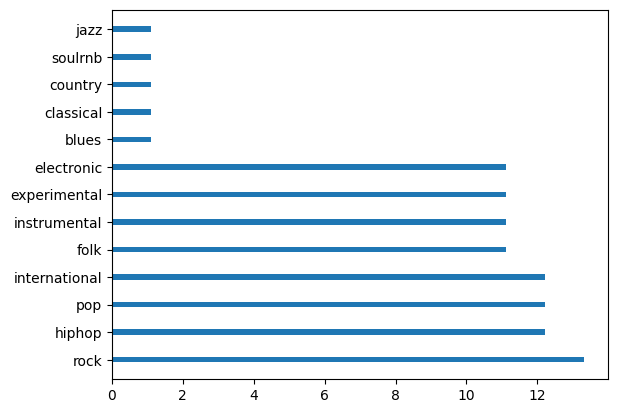

In [70]:
plt.barh(class_dis.label, class_dis.proportion, .2)

In [84]:
unique_labels = class_dataset_dist.sort_values(by='label').label.unique()
unique_labels,class_dataset_dist[class_dataset_dist.dataset == 'fma'].sort_values(by='label'),class_dataset_dist[class_dataset_dist.dataset != 'fma']
#plt.barh(class_dataset_dist.label, class_dataset_dist.proportion, .2, )

(array(['blues', 'classical', 'country', 'electronic', 'experimental',
        'folk', 'hiphop', 'instrumental', 'international', 'jazz', 'pop',
        'rock', 'soulrnb'], dtype=object),
            label dataset  proportion
 5     electronic     fma   11.104936
 7   experimental     fma   11.104936
 3           folk     fma   11.116052
 0         hiphop     fma   11.116052
 2   instrumental     fma   11.116052
 4  international     fma   11.116052
 1            pop     fma   11.116052
 6           rock     fma   11.104936,
             label dataset  proportion
 8            rock   gtzan    2.223210
 9           blues   gtzan    1.111605
 10         hiphop   gtzan    1.111605
 11        country   gtzan    1.111605
 12      classical   gtzan    1.111605
 13            pop   gtzan    1.111605
 14  international   gtzan    1.111605
 15        soulrnb   gtzan    1.111605
 16           jazz   gtzan    1.100489)

the classes are imbalanced, which might need to be remediated for a classificaiton algorithm. Minority class might not be correctly predicted. 

## Calculate distance between groups based on chroma_shift

In [23]:
#sampled_df = data_df.groupby('label').sample(n=99)

sampled_df = data_df

def ec_distance(group1, group2):
    distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(group1, group2)]))
    return distance


genres = data_df['label'].unique()

dist_df = {}
for i in genres:
    for j in genres:

        group1 = sampled_df[sampled_df['label']==i]['tempo']
        group2 = sampled_df[sampled_df['label']==j]['tempo']
        
        if i==j: 
            continue
        if (j,i) in dist_df:
            continue
        else:
            dist = ec_distance(group1, group2)
            dist_df[i,j] = round(dist,2)
        
dist_df_sorted = dict(sorted(dist_df.items(), key=lambda item: item[1]))

dist_df_top20 = pd.DataFrame(dist_df_sorted.items(), columns=['genres', 'similarity']).head(20)
dist_df_top20

genres  similarity
0      (experimental, soulrnb)      167.94
1              (rock, soulrnb)      210.89
2    (experimental, classical)      216.73
3              (folk, soulrnb)      217.08
4      (instrumental, soulrnb)      221.37
5                 (rock, jazz)      222.84
6        (electronic, soulrnb)      228.09
7     (international, soulrnb)      228.54
8            (rock, classical)      230.25
9               (pop, soulrnb)      233.39
10             (soulrnb, jazz)      234.40
11        (classical, soulrnb)      235.50
12            (pop, classical)      240.01
13        (experimental, jazz)      243.84
14   (instrumental, classical)      247.44
15       (international, jazz)      248.38
16           (folk, classical)      253.75
17          (country, soulrnb)      265.60
18                (folk, jazz)      266.08
19  (international, classical)      267.93

ValueError: Names should be list-like for a MultiIndex

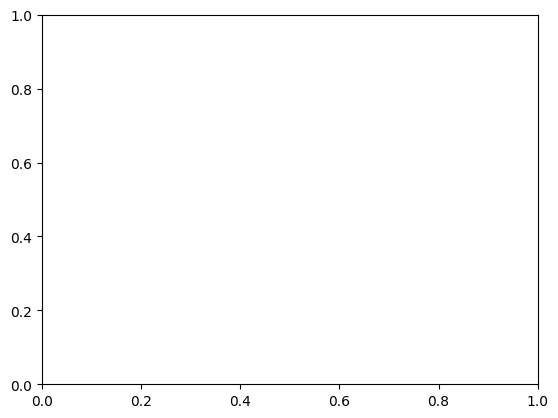

In [24]:
sns.barplot(x = 'similarity',
            y = 'genres',
            data = dist_df_top20)

plt.title("Most similar genre based on the tempo feature")

# Class imblanance remidiation using SMOTE

In [85]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

y = data_df['label']
x = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

x_smote, y_smote = smote.fit_resample(x, y)

#x_smote, y_smote = x,y


y_smote.value_counts()

label
hiphop           1199
pop              1199
folk             1199
experimental     1199
rock             1199
international    1199
electronic       1199
instrumental     1199
blues            1199
classical        1199
country          1199
soulrnb          1199
jazz             1199
Name: count, dtype: int64

In [86]:
smote_df = x_smote.copy()
smote_df['label'] = y_smote

In [87]:
def ec_distance(group1, group2):
    distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(group1, group2)]))
    return distance


genres = smote_df['label'].unique()

dist_df = {}
for i in genres:
    for j in genres:

        group1 = smote_df[smote_df['label']==i]['tempo']
        group2 = smote_df[smote_df['label']==j]['tempo']
        
        if i==j: 
            continue
        if (j,i) in dist_df:
            continue
        else:
            dist = ec_distance(group1, group2)
            dist_df[i,j] = round(dist,2)
        
dist_df_sorted = dict(sorted(dist_df.items(), key=lambda item: item[1]))

dist_df_top20 = pd.DataFrame(dist_df_sorted.items(), columns=['genres', 'similarity']).head(20)
dist_df_top20

genres  similarity
0        (experimental, soulrnb)      643.67
1           (classical, soulrnb)      649.49
2                (soulrnb, jazz)      655.07
3                (folk, soulrnb)      707.05
4        (instrumental, soulrnb)      719.82
5      (experimental, classical)      721.35
6          (electronic, soulrnb)      727.26
7              (classical, jazz)      763.02
8                 (pop, soulrnb)      765.05
9                (rock, soulrnb)      768.69
10          (experimental, jazz)      770.96
11            (country, soulrnb)      771.90
12              (blues, soulrnb)      780.65
13             (folk, classical)      781.00
14                  (folk, jazz)      783.88
15             (rock, classical)      804.78
16          (folk, experimental)      804.81
17  (experimental, instrumental)      813.04
18              (pop, classical)      814.32
19    (experimental, electronic)      814.48

ValueError: Names should be list-like for a MultiIndex

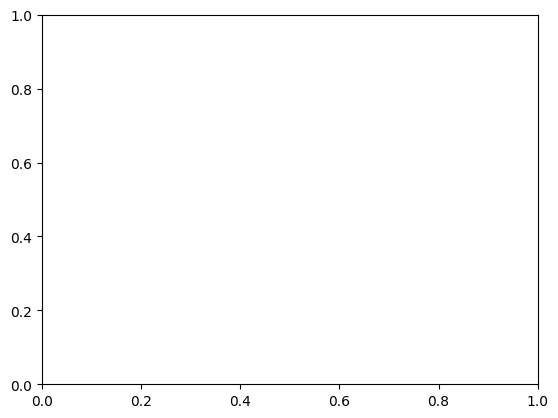

In [88]:
sns.barplot(x = 'similarity',
            y = 'genres',
            data = dist_df_top20)

plt.title("Most similar genre based on the tempo feature")

Distance value between classes increased

# Classificaiton 

## Original dataset with all vars 

In [29]:
y_original = data_df['label']
x_original = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(x_original, y_original, test_size=0.2, random_state=42)

RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_og, y_train_og)

y_pred_og = RandomForest.predict(X_test_og)

In [89]:
print(classification_report(y_test_og, y_pred_og))

               precision    recall  f1-score   support

        blues       0.68      0.81      0.74        16
    classical       0.83      0.83      0.83        18
      country       0.50      0.39      0.44        23
   electronic       0.53      0.42      0.47       193
 experimental       0.46      0.37      0.41       206
         folk       0.52      0.58      0.55       196
       hiphop       0.58      0.66      0.62       249
 instrumental       0.52      0.49      0.51       200
international       0.48      0.53      0.50       228
         jazz       0.53      0.50      0.52        16
          pop       0.38      0.32      0.35       198
         rock       0.52      0.62      0.57       242
      soulrnb       0.41      0.47      0.44        15

     accuracy                           0.51      1800
    macro avg       0.54      0.54      0.53      1800
 weighted avg       0.51      0.51      0.51      1800



## Full dataset/ smote for imbalanced classes

In [90]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_smote, y_train_smote)

y_pred_smote = RandomForest.predict(X_test_smote)

In [91]:
print(classification_report(y_test_smote, y_pred_smote))

               precision    recall  f1-score   support

        blues       0.96      0.98      0.97       257
    classical       0.98      1.00      0.99       226
      country       0.92      0.99      0.96       248
   electronic       0.56      0.48      0.52       239
 experimental       0.50      0.48      0.49       232
         folk       0.56      0.68      0.61       260
       hiphop       0.59      0.65      0.62       239
 instrumental       0.59      0.61      0.60       244
international       0.57      0.60      0.58       232
         jazz       0.95      0.98      0.97       190
          pop       0.40      0.26      0.31       246
         rock       0.61      0.57      0.59       253
      soulrnb       0.94      0.99      0.96       252

     accuracy                           0.71      3118
    macro avg       0.70      0.71      0.70      3118
 weighted avg       0.70      0.71      0.70      3118



In [92]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train_smote,y_train_smote)

y_pred_smote_dt = clf.predict(X_test_smote)

In [93]:
print(classification_report(y_test_smote, y_pred_smote_dt))

               precision    recall  f1-score   support

        blues       0.93      0.89      0.91       257
    classical       0.97      0.96      0.96       226
      country       0.85      0.91      0.88       248
   electronic       0.38      0.35      0.36       239
 experimental       0.27      0.28      0.27       232
         folk       0.46      0.47      0.46       260
       hiphop       0.48      0.44      0.46       239
 instrumental       0.38      0.39      0.38       244
international       0.41      0.43      0.42       232
         jazz       0.82      0.89      0.86       190
          pop       0.21      0.22      0.22       246
         rock       0.43      0.38      0.40       253
      soulrnb       0.91      0.93      0.92       252

     accuracy                           0.58      3118
    macro avg       0.58      0.58      0.58      3118
 weighted avg       0.57      0.58      0.57      3118



In [94]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train_smote,y_train_smote)
y_pred_smote_lm = lm.predict(X_test_smote)

/Users/murphybre/Desktop/UMichigan/Fall2024/siads699_capstone/music_modeling_capstone/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [95]:
print(classification_report(y_test_smote, y_pred_smote_lm))

               precision    recall  f1-score   support

        blues       0.63      0.82      0.71       257
    classical       0.70      0.86      0.77       226
      country       0.46      0.40      0.43       248
   electronic       0.32      0.31      0.31       239
 experimental       0.30      0.23      0.26       232
         folk       0.42      0.59      0.49       260
       hiphop       0.43      0.46      0.44       239
 instrumental       0.38      0.45      0.41       244
international       0.33      0.14      0.19       232
         jazz       0.53      0.49      0.51       190
          pop       0.13      0.03      0.05       246
         rock       0.42      0.45      0.44       253
      soulrnb       0.61      0.88      0.73       252

     accuracy                           0.47      3118
    macro avg       0.43      0.47      0.44      3118
 weighted avg       0.43      0.47      0.44      3118



## Reduced features/ smote for class imbalance 

In [96]:
#take out two features that do not have much variation based on genre 
# 'spectral_centroids_delta_mean',
# 'spectral_centroids_accelerate_mean',

y_sm = data_df['label']
x_sm = data_df[['spectral_centroids_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
             'onset',
               'mfccs_min']]

x_smote_sm, y_smote_sm = smote.fit_resample(x_sm, y_sm)

In [97]:
X_train_smote_sm, X_test_smote_sm, y_train_smote_sm, y_test_smote_sm = train_test_split(x_smote_sm, y_smote_sm, test_size=0.2, random_state=42)


In [98]:
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_smote_sm, y_train_smote_sm)

y_pred_smote_sm = RandomForest.predict(X_test_smote_sm)

In [99]:
print(classification_report(y_test_smote_sm, y_pred_smote_sm))

               precision    recall  f1-score   support

        blues       0.92      0.96      0.94       257
    classical       0.97      1.00      0.98       226
      country       0.92      0.97      0.94       248
   electronic       0.50      0.44      0.47       239
 experimental       0.40      0.34      0.37       232
         folk       0.46      0.57      0.51       260
       hiphop       0.51      0.57      0.54       239
 instrumental       0.53      0.55      0.54       244
international       0.51      0.55      0.53       232
         jazz       0.92      0.96      0.94       190
          pop       0.39      0.26      0.32       246
         rock       0.55      0.49      0.52       253
      soulrnb       0.90      0.97      0.94       252

     accuracy                           0.66      3118
    macro avg       0.65      0.66      0.66      3118
 weighted avg       0.65      0.66      0.65      3118



## Try to tune parameters for Random Forest

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [39]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_test_smote, y_test_smote)

rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   9.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  16.4s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  16.9s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  17.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   9.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  11.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total 

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 90,
 'bootstrap': True}

In [100]:
best_params = {'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

In [101]:
RandomForest_2 = RandomForestClassifier(random_state=42,
                                     n_estimators=  1200,
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     max_depth = 40,
                                     bootstrap = True)

RandomForest_2.fit(X_train_smote, y_train_smote)

y_pred_smote = RandomForest_2.predict(X_test_smote)

In [102]:
print(classification_report(y_test_smote, y_pred_smote))

               precision    recall  f1-score   support

        blues       0.97      0.99      0.98       257
    classical       0.98      1.00      0.99       226
      country       0.93      0.99      0.96       248
   electronic       0.59      0.48      0.53       239
 experimental       0.52      0.47      0.49       232
         folk       0.56      0.67      0.61       260
       hiphop       0.58      0.64      0.61       239
 instrumental       0.59      0.61      0.60       244
international       0.54      0.59      0.56       232
         jazz       0.96      0.98      0.97       190
          pop       0.39      0.25      0.30       246
         rock       0.58      0.57      0.57       253
      soulrnb       0.93      0.99      0.96       252

     accuracy                           0.71      3118
    macro avg       0.70      0.71      0.70      3118
 weighted avg       0.70      0.71      0.70      3118



In [103]:
round(accuracy_score(y_test_smote, y_pred_smote),2)

0.71